In [13]:
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import models
from models import MNIST_target_net
import cv2, os
import numpy as np

from utils.NonBayesianModels.AlexNet import AlexNet

In [2]:
use_cuda=True
image_nc= 3
batch_size = 1
saving_path = './dataset/advCifar10'

gen_input_nc = image_nc

print("CUDA Available: ",torch.cuda.is_available())
#device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
device = 'cpu'

pretrained_model = "./CIFAR10_target_model.pth"
target_model = AlexNet(10).to(device)
target_model.load_state_dict(torch.load(pretrained_model))
target_model.eval()

pretrained_generator_path = './models/netG_epoch_60.pth'
pretrained_G = models.Generator(gen_input_nc, image_nc).to(device)
pretrained_G.load_state_dict(torch.load(pretrained_generator_path))
pretrained_G.eval()

CUDA Available:  True


Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU()
  )
  (bottle_neck): Sequential(
    (0): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): 

In [4]:
mnist_dataset = torchvision.datasets.CIFAR10('./dataset', train=True, transform=transforms.ToTensor(), download=True)
train_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
num_correct = 0
print(len(train_dataloader))

Files already downloaded and verified
50000


In [60]:
for i, data in enumerate(train_dataloader, 0):
    test_img, test_label = data
    test_img, test_label = test_img.to(device), test_label.to(device)
    perturbation = pretrained_G(test_img)
    perturbation = torch.clamp(perturbation, -0.3, 0.3)
    adv_img = perturbation + test_img
    adv_img = torch.clamp(adv_img, 0, 1)
    pred_lab = torch.argmax(target_model(adv_img),1)
    num_correct += torch.sum(pred_lab==test_label,0)
    file_name = os.path.join(saving_path, str(i)+'_'+str(test_label.detach().numpy()[0])+'.jpg')
    img = np.squeeze(adv_img.detach().numpy())
    img = np.transpose(img * 255, (1,2,0))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    cv2.imwrite(file_name, img)

In [27]:
import os
import matplotlib.pyplot as plt

(32, 32, 3)


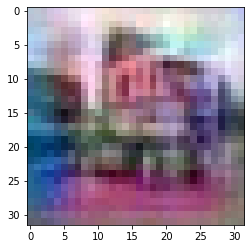

In [61]:
file = os.listdir(saving_path)
path = os.path.join(saving_path, file[0])
img = cv2.imread(path)
print(img.shape)
b, g, r = cv2.split(img)
img = cv2.merge([r, g, b])
plt.figure()
plt.imshow(img)
plt.show()

In [62]:
path

'./dataset/advCifar10/43226_9.jpg'

In [64]:
file[0]

'43226_9.jpg'

In [67]:
a = file[0].split('_')[1]
a = a.split('.')[0]
a

'9'

In [68]:
type(a)

str

In [69]:
from MyDataSet.advTrainingSet import advData

In [75]:
if __name__ == '__main__':
    p = advData(saving_path)
    print(p.__len__())
    data, label = p.__getitem__(30)
    print(type(data))
    print(label)

50000


TypeError: 'list' object is not callable